In [1]:
# Kernel deepesdl-xcube-1.7.1

In [2]:
import datetime
import json
import logging
import os

from xcube.core.store import new_data_store
import numpy as np
import xarray as xr


logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

LOG = logging.getLogger("MyLogger")

In [3]:
with open("cds-credentials.json") as f:
    credentials = json.load(f)

cds_store = new_data_store(
    "cds",
    **credentials,
    normalize_names=True,
)

In [4]:
store_team = new_data_store(
    "s3",
    root=os.environ["S3_USER_STORAGE_BUCKET"],
    max_depth=4,
    storage_options=dict(
        anon=False,
        key=os.environ["S3_USER_STORAGE_KEY"],
        secret=os.environ["S3_USER_STORAGE_SECRET"],
    ),
)

In [5]:
def get_time_ranges():
    years = np.arange(1981, 2025)
    time_ranges = []
    for year in years:
        time_ranges.append([f"{year}-01-01", f"{year}-12-31"])
    return time_ranges

time_ranges = get_time_ranges()
time_ranges

[['1981-01-01', '1981-12-31'],
 ['1982-01-01', '1982-12-31'],
 ['1983-01-01', '1983-12-31'],
 ['1984-01-01', '1984-12-31'],
 ['1985-01-01', '1985-12-31'],
 ['1986-01-01', '1986-12-31'],
 ['1987-01-01', '1987-12-31'],
 ['1988-01-01', '1988-12-31'],
 ['1989-01-01', '1989-12-31'],
 ['1990-01-01', '1990-12-31'],
 ['1991-01-01', '1991-12-31'],
 ['1992-01-01', '1992-12-31'],
 ['1993-01-01', '1993-12-31'],
 ['1994-01-01', '1994-12-31'],
 ['1995-01-01', '1995-12-31'],
 ['1996-01-01', '1996-12-31'],
 ['1997-01-01', '1997-12-31'],
 ['1998-01-01', '1998-12-31'],
 ['1999-01-01', '1999-12-31'],
 ['2000-01-01', '2000-12-31'],
 ['2001-01-01', '2001-12-31'],
 ['2002-01-01', '2002-12-31'],
 ['2003-01-01', '2003-12-31'],
 ['2004-01-01', '2004-12-31'],
 ['2005-01-01', '2005-12-31'],
 ['2006-01-01', '2006-12-31'],
 ['2007-01-01', '2007-12-31'],
 ['2008-01-01', '2008-12-31'],
 ['2009-01-01', '2009-12-31'],
 ['2010-01-01', '2010-12-31'],
 ['2011-01-01', '2011-12-31'],
 ['2012-01-01', '2012-12-31'],
 ['2013-

In [6]:
# extract ERA5 from CDS
data_id = "reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis"
bbox = [-5, 40, 35, 65]
variable_names = [
    "soil_temperature_level_1",
    "soil_temperature_level_2",
    "soil_temperature_level_3",
    "soil_temperature_level_4",
    "2m_dewpoint_temperature",
    "evaporation",
    "leaf_area_index_high_vegetation",
    "leaf_area_index_low_vegetation",
    "potential_evaporation",
    "skin_temperature",
    "surface_latent_heat_flux",
    "surface_pressure",
    "surface_sensible_heat_flux",
    "surface_net_solar_radiation",
    "2m_temperature",
    "total_precipitation",
]

for time_range in time_ranges:
    LOG.info(f"Cube generation started for {time_range}")
    ds = cds_store.open_data(
        data_id,
        "dataset:netcdf:cds",
        variable_names=variable_names,
        bbox=bbox,
        spatial_res=0.25,
        time_range=time_range,
    )
    file_name = time_range[0][:4]
    ds0 = ds[["e", "pev", "slhf", "sshf", "ssr", "tp"]]
    ds1 = ds[["lai_lv", "lai_hv", "sp", "t2m", "d2m", "skt", "stl1", "stl2", "stl3", "stl4"]]
    ds0 = ds0.isel(time=np.arange(1, 24, 2))
    ds1 = ds1.isel(time=np.arange(0, 24, 2))
    ds0 = ds0.assign_coords(dict(time=ds1.time))
    ds = xr.merge([ds0, ds1])
    store_team.write_data(ds, f"cubes/aux/era5_monthly/{file_name}.zarr", replace=True)
    LOG.info(f"ERA5 for {time_range} is written to {file_name}.zarr")
    
    # open dataset and check for nan values
    ds = store_team.open_data(f"cubes/aux/era5_monthly/{file_name}.zarr")
    for var in ds.data_vars:
        vals = ds[var].values
        nans = vals[np.isnan(vals)]
        if nans.size > 0:
            LOG.info(
                f"File cubes/aux/era5_monthly/{file_name}.zarr has {nans.size} nan"
                f"values for variable name {var}."
            )

2025-02-03 15:25:08,781 - INFO - Cube generation started for ['1981-01-01', '1981-12-31']
xcube-cds version 0.9.3
2025-02-03 15:25:13,909 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:25:13,909 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:25:13,911 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-02-03 15:25:13,911 - WARNING - [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for yo

6809f3d9d6cd6380215dd36c1a282cc4.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:25:31,420 - INFO - ERA5 for ['1981-01-01', '1981-12-31'] is written to 1981.zarr
2025-02-03 15:25:31,955 - INFO - Cube generation started for ['1982-01-01', '1982-12-31']
xcube-cds version 0.9.3
2025-02-03 15:25:32,029 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:25:32,029 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

3aef08a598ce1d82ee69dabfdcfdc693.zip:   0%|          | 0.00/5.64M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:26:12,826 - INFO - ERA5 for ['1982-01-01', '1982-12-31'] is written to 1982.zarr
2025-02-03 15:26:13,375 - INFO - Cube generation started for ['1983-01-01', '1983-12-31']
xcube-cds version 0.9.3
2025-02-03 15:26:13,443 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:26:13,443 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

e74f6c88003dfa4fe043b779a536039f.zip:   0%|          | 0.00/5.63M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:26:54,328 - INFO - ERA5 for ['1983-01-01', '1983-12-31'] is written to 1983.zarr
2025-02-03 15:26:54,918 - INFO - Cube generation started for ['1984-01-01', '1984-12-31']
xcube-cds version 0.9.3
2025-02-03 15:27:00,006 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:27:00,006 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

24c8597f9339a08762e63459a155c9b9.zip:   0%|          | 0.00/5.63M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:27:42,153 - INFO - ERA5 for ['1984-01-01', '1984-12-31'] is written to 1984.zarr
2025-02-03 15:27:42,685 - INFO - Cube generation started for ['1985-01-01', '1985-12-31']
xcube-cds version 0.9.3
2025-02-03 15:27:47,758 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:27:47,758 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

fa58dccb273f7d294353f71ea573bbd5.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:28:28,908 - INFO - ERA5 for ['1985-01-01', '1985-12-31'] is written to 1985.zarr
2025-02-03 15:28:29,415 - INFO - Cube generation started for ['1986-01-01', '1986-12-31']
xcube-cds version 0.9.3
2025-02-03 15:28:29,500 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:28:29,500 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

a96d5eb625052e46a99dd9c3922c3ac9.zip:   0%|          | 0.00/5.61M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:29:10,037 - INFO - ERA5 for ['1986-01-01', '1986-12-31'] is written to 1986.zarr
2025-02-03 15:29:10,571 - INFO - Cube generation started for ['1987-01-01', '1987-12-31']
xcube-cds version 0.9.3
2025-02-03 15:29:15,676 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:29:15,676 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

f14041a14cfca8f03d16a613f89a6c12.zip:   0%|          | 0.00/5.61M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:29:56,383 - INFO - ERA5 for ['1987-01-01', '1987-12-31'] is written to 1987.zarr
2025-02-03 15:29:56,879 - INFO - Cube generation started for ['1988-01-01', '1988-12-31']
xcube-cds version 0.9.3
2025-02-03 15:30:06,942 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:30:06,942 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

4d28581db3007c35461110cffa31c2f1.zip:   0%|          | 0.00/5.63M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:30:47,733 - INFO - ERA5 for ['1988-01-01', '1988-12-31'] is written to 1988.zarr
2025-02-03 15:30:48,246 - INFO - Cube generation started for ['1989-01-01', '1989-12-31']
xcube-cds version 0.9.3
2025-02-03 15:30:48,349 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:30:48,349 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

dd399c7dd633142a7f52c8d8201cf7b4.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:31:46,256 - INFO - ERA5 for ['1989-01-01', '1989-12-31'] is written to 1989.zarr
2025-02-03 15:31:46,780 - INFO - Cube generation started for ['1990-01-01', '1990-12-31']
xcube-cds version 0.9.3
2025-02-03 15:31:46,864 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:31:46,864 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

bde27059ffa1d73633109d13ded097.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:32:28,032 - INFO - ERA5 for ['1990-01-01', '1990-12-31'] is written to 1990.zarr
2025-02-03 15:32:28,610 - INFO - Cube generation started for ['1991-01-01', '1991-12-31']
xcube-cds version 0.9.3
2025-02-03 15:32:28,706 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:32:28,706 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

6ed18a48a21fb5d10860ac5619aa6659.zip:   0%|          | 0.00/5.63M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:33:09,800 - INFO - ERA5 for ['1991-01-01', '1991-12-31'] is written to 1991.zarr
2025-02-03 15:33:10,323 - INFO - Cube generation started for ['1992-01-01', '1992-12-31']
xcube-cds version 0.9.3
2025-02-03 15:33:15,398 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:33:15,398 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

f2252c5d1a8d29f43440a896e5f81700.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:33:56,389 - INFO - ERA5 for ['1992-01-01', '1992-12-31'] is written to 1992.zarr
2025-02-03 15:33:56,932 - INFO - Cube generation started for ['1993-01-01', '1993-12-31']
xcube-cds version 0.9.3
2025-02-03 15:33:57,051 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:33:57,051 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

bcd0b75ee4cdebef0716f343c53d782f.zip:   0%|          | 0.00/5.63M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:34:39,110 - INFO - ERA5 for ['1993-01-01', '1993-12-31'] is written to 1993.zarr
2025-02-03 15:34:39,628 - INFO - Cube generation started for ['1994-01-01', '1994-12-31']
xcube-cds version 0.9.3
2025-02-03 15:34:39,703 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:34:39,703 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

6a6dbdea653ed6d9f16ca2f61fb59004.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:35:21,219 - INFO - ERA5 for ['1994-01-01', '1994-12-31'] is written to 1994.zarr
2025-02-03 15:35:21,759 - INFO - Cube generation started for ['1995-01-01', '1995-12-31']
xcube-cds version 0.9.3
2025-02-03 15:35:21,824 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:35:21,824 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

36391469d5129947578228d999c458a0.zip:   0%|          | 0.00/5.63M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:36:04,780 - INFO - ERA5 for ['1995-01-01', '1995-12-31'] is written to 1995.zarr
2025-02-03 15:36:05,349 - INFO - Cube generation started for ['1996-01-01', '1996-12-31']
xcube-cds version 0.9.3
2025-02-03 15:36:05,432 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:36:05,432 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

cd7b9089774599813732d191a4bf3dd5.zip:   0%|          | 0.00/5.64M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:37:03,516 - INFO - ERA5 for ['1996-01-01', '1996-12-31'] is written to 1996.zarr
2025-02-03 15:37:04,022 - INFO - Cube generation started for ['1997-01-01', '1997-12-31']
xcube-cds version 0.9.3
2025-02-03 15:37:04,118 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:37:04,118 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

56ebbad5f3d369cce39d56b4ad3f819a.zip:   0%|          | 0.00/5.63M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:37:44,855 - INFO - ERA5 for ['1997-01-01', '1997-12-31'] is written to 1997.zarr
2025-02-03 15:37:45,368 - INFO - Cube generation started for ['1998-01-01', '1998-12-31']
xcube-cds version 0.9.3
2025-02-03 15:37:50,476 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:37:50,476 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

e99241cb5939fca75579fa371adc37ba.zip:   0%|          | 0.00/5.61M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:38:31,339 - INFO - ERA5 for ['1998-01-01', '1998-12-31'] is written to 1998.zarr
2025-02-03 15:38:31,847 - INFO - Cube generation started for ['1999-01-01', '1999-12-31']
xcube-cds version 0.9.3
2025-02-03 15:38:36,940 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:38:36,940 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

56905681575d45579c78f01fa9c090d3.zip:   0%|          | 0.00/5.64M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:39:06,928 - INFO - ERA5 for ['1999-01-01', '1999-12-31'] is written to 1999.zarr
2025-02-03 15:39:07,471 - INFO - Cube generation started for ['2000-01-01', '2000-12-31']
xcube-cds version 0.9.3
2025-02-03 15:39:12,565 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:39:12,565 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

c34a39bf2a1347f287b43986c83f535.zip:   0%|          | 0.00/5.64M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:39:53,480 - INFO - ERA5 for ['2000-01-01', '2000-12-31'] is written to 2000.zarr
2025-02-03 15:39:53,979 - INFO - Cube generation started for ['2001-01-01', '2001-12-31']
xcube-cds version 0.9.3
2025-02-03 15:39:54,043 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:39:54,043 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

b8353463b0b789e5ef7ab97237d9e8ea.zip:   0%|          | 0.00/5.63M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:40:34,997 - INFO - ERA5 for ['2001-01-01', '2001-12-31'] is written to 2001.zarr
2025-02-03 15:40:35,510 - INFO - Cube generation started for ['2002-01-01', '2002-12-31']
xcube-cds version 0.9.3
2025-02-03 15:40:35,607 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:40:35,607 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

a242fe54c30c5d7431df682ccc7f26b3.zip:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:41:36,081 - INFO - ERA5 for ['2002-01-01', '2002-12-31'] is written to 2002.zarr
2025-02-03 15:41:36,648 - INFO - Cube generation started for ['2003-01-01', '2003-12-31']
xcube-cds version 0.9.3
2025-02-03 15:41:36,725 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:41:36,725 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

fbe1a03de1992a74d91c7eaa927f9bea.zip:   0%|          | 0.00/5.63M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:42:17,878 - INFO - ERA5 for ['2003-01-01', '2003-12-31'] is written to 2003.zarr
2025-02-03 15:42:18,477 - INFO - Cube generation started for ['2004-01-01', '2004-12-31']
xcube-cds version 0.9.3
2025-02-03 15:42:28,575 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:42:28,575 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

15743b2c55b7a49710a87fb3b50ba96.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:43:09,309 - INFO - ERA5 for ['2004-01-01', '2004-12-31'] is written to 2004.zarr
2025-02-03 15:43:10,093 - INFO - Cube generation started for ['2005-01-01', '2005-12-31']
xcube-cds version 0.9.3
2025-02-03 15:43:10,193 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:43:10,193 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

1151965b6afd6c0e1858649e9dd7fbfc.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:43:51,235 - INFO - ERA5 for ['2005-01-01', '2005-12-31'] is written to 2005.zarr
2025-02-03 15:43:51,758 - INFO - Cube generation started for ['2006-01-01', '2006-12-31']
xcube-cds version 0.9.3
2025-02-03 15:43:51,835 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:43:51,835 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

304d8216c8d72d82b95fd55ef48499da.zip:   0%|          | 0.00/5.63M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:45:58,298 - INFO - ERA5 for ['2007-01-01', '2007-12-31'] is written to 2007.zarr
2025-02-03 15:45:58,802 - INFO - Cube generation started for ['2008-01-01', '2008-12-31']
xcube-cds version 0.9.3
2025-02-03 15:45:58,877 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:45:58,877 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

155b465f4c32b2c4e18ded26bff54835.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:46:39,629 - INFO - ERA5 for ['2008-01-01', '2008-12-31'] is written to 2008.zarr
2025-02-03 15:46:40,257 - INFO - Cube generation started for ['2009-01-01', '2009-12-31']
xcube-cds version 0.9.3
2025-02-03 15:46:40,349 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:46:40,349 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

7b392a670386907645feee32d45636c5.zip:   0%|          | 0.00/5.64M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:47:37,775 - INFO - ERA5 for ['2009-01-01', '2009-12-31'] is written to 2009.zarr
2025-02-03 15:47:38,328 - INFO - Cube generation started for ['2010-01-01', '2010-12-31']
xcube-cds version 0.9.3
2025-02-03 15:47:38,430 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:47:38,430 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

15f3e9ba583d6747f591d995d0113d70.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:48:36,968 - INFO - ERA5 for ['2010-01-01', '2010-12-31'] is written to 2010.zarr
2025-02-03 15:48:37,506 - INFO - Cube generation started for ['2011-01-01', '2011-12-31']
xcube-cds version 0.9.3
2025-02-03 15:48:37,580 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:48:37,580 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

3f8006056a6ef683ee5015afd61fde1f.zip:   0%|          | 0.00/5.61M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:49:18,144 - INFO - ERA5 for ['2011-01-01', '2011-12-31'] is written to 2011.zarr
2025-02-03 15:49:18,652 - INFO - Cube generation started for ['2012-01-01', '2012-12-31']
xcube-cds version 0.9.3
2025-02-03 15:49:18,753 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:49:18,753 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

41fe8ad48607a673c4c1c58bb71d41c2.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:49:59,620 - INFO - ERA5 for ['2012-01-01', '2012-12-31'] is written to 2012.zarr
2025-02-03 15:50:00,169 - INFO - Cube generation started for ['2013-01-01', '2013-12-31']
xcube-cds version 0.9.3
2025-02-03 15:50:00,246 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:50:00,246 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

c61671f1dd2dec4b1208abee3fe24dcc.zip:   0%|          | 0.00/5.64M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:50:58,374 - INFO - ERA5 for ['2013-01-01', '2013-12-31'] is written to 2013.zarr
2025-02-03 15:50:58,929 - INFO - Cube generation started for ['2014-01-01', '2014-12-31']
xcube-cds version 0.9.3
2025-02-03 15:50:58,992 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:50:58,992 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

efdb12cbc0d700abd1e66f9040b81918.zip:   0%|          | 0.00/5.64M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:51:41,701 - INFO - ERA5 for ['2014-01-01', '2014-12-31'] is written to 2014.zarr
2025-02-03 15:51:42,210 - INFO - Cube generation started for ['2015-01-01', '2015-12-31']
xcube-cds version 0.9.3
2025-02-03 15:51:42,308 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:51:42,308 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

6bfcdc549e387ff981d3a89893d76173.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:52:41,783 - INFO - ERA5 for ['2015-01-01', '2015-12-31'] is written to 2015.zarr
2025-02-03 15:52:42,277 - INFO - Cube generation started for ['2016-01-01', '2016-12-31']
xcube-cds version 0.9.3
2025-02-03 15:52:42,361 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:52:42,361 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

fbfbf19d314839b00b01caed1cbad2bb.zip:   0%|          | 0.00/5.64M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:53:23,122 - INFO - ERA5 for ['2016-01-01', '2016-12-31'] is written to 2016.zarr
2025-02-03 15:53:23,632 - INFO - Cube generation started for ['2017-01-01', '2017-12-31']
xcube-cds version 0.9.3
2025-02-03 15:53:28,738 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:53:28,738 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

b056d28109bf069e83a97810327bfebd.zip:   0%|          | 0.00/5.60M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:54:09,302 - INFO - ERA5 for ['2017-01-01', '2017-12-31'] is written to 2017.zarr
2025-02-03 15:54:09,878 - INFO - Cube generation started for ['2018-01-01', '2018-12-31']
xcube-cds version 0.9.3
2025-02-03 15:54:09,993 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:54:09,993 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

9b0ae0d88326ced8b8003268e650ec9a.zip:   0%|          | 0.00/5.66M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:54:50,693 - INFO - ERA5 for ['2018-01-01', '2018-12-31'] is written to 2018.zarr
2025-02-03 15:54:51,248 - INFO - Cube generation started for ['2019-01-01', '2019-12-31']
xcube-cds version 0.9.3
2025-02-03 15:54:56,348 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:54:56,348 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

152d074ad29114cafd57ed7bc15b30c2.zip:   0%|          | 0.00/5.64M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:55:37,336 - INFO - ERA5 for ['2019-01-01', '2019-12-31'] is written to 2019.zarr
2025-02-03 15:55:37,862 - INFO - Cube generation started for ['2020-01-01', '2020-12-31']
xcube-cds version 0.9.3
2025-02-03 15:55:37,958 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:55:37,958 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

56d0343c95606c7930f6b58ef76ec793.zip:   0%|          | 0.00/5.62M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:56:07,043 - INFO - ERA5 for ['2020-01-01', '2020-12-31'] is written to 2020.zarr
2025-02-03 15:56:07,622 - INFO - Cube generation started for ['2021-01-01', '2021-12-31']
xcube-cds version 0.9.3
2025-02-03 15:56:12,725 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:56:12,725 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

3788a3945a635132449213074f5c6046.zip:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:56:42,018 - INFO - ERA5 for ['2021-01-01', '2021-12-31'] is written to 2021.zarr
2025-02-03 15:56:42,538 - INFO - Cube generation started for ['2022-01-01', '2022-12-31']
xcube-cds version 0.9.3
2025-02-03 15:56:42,625 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:56:42,625 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

86c41e34307df838d635354c8ee9953b.zip:   0%|          | 0.00/5.66M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:57:23,080 - INFO - ERA5 for ['2022-01-01', '2022-12-31'] is written to 2022.zarr
2025-02-03 15:57:23,632 - INFO - Cube generation started for ['2023-01-01', '2023-12-31']
xcube-cds version 0.9.3
2025-02-03 15:57:23,728 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:57:23,728 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

7a994e01820601089bc8756a131865c0.zip:   0%|          | 0.00/5.63M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:58:04,910 - INFO - ERA5 for ['2023-01-01', '2023-12-31'] is written to 2023.zarr
2025-02-03 15:58:05,488 - INFO - Cube generation started for ['2024-01-01', '2024-12-31']
xcube-cds version 0.9.3
2025-02-03 15:58:05,554 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-02-03 15:58:05,554 - INFO - [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topic

50fe0fd09cba407bba41e006c2919bed.zip:   0%|          | 0.00/5.64M [00:00<?, ?B/s]

/home/conda/deepesdl/84b268c1c171938f0f81e0485444162306485a62c61d0c4f182d71542b58abb3-20250106-111856-550739-628-xcube-1.7.1/lib/python3.12/site-packages/xcube/core/store/fs/impl/dataset.py:183: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  data.to_zarr(
2025-02-03 15:59:29,439 - INFO - ERA5 for ['2024-01-01', '2024-12-31'] is written to 2024.zarr


In [7]:
# open dataset and check for nan values
for file_name in range(1981, 2025):
    ds = store_team.open_data(f"cubes/aux/era5_monthly/{file_name}.zarr")
    for var in ds.data_vars:
        vals = ds[var].values
        nans = vals[np.isnan(vals)]
        if nans.size > 0:
            LOG.info(
                f"File cubes/aux/era5_monthly/{file_name}.zarr has {nans.size} nan"
                f"values for variable name {var}."
            )

In [8]:
data_ids = store_team.list_data_ids()
data_ids = [data_id for data_id in data_ids if "cubes/aux/era5_monthly/" in data_id]
data_ids

['cubes/aux/era5_monthly/1981.zarr',
 'cubes/aux/era5_monthly/1982.zarr',
 'cubes/aux/era5_monthly/1983.zarr',
 'cubes/aux/era5_monthly/1984.zarr',
 'cubes/aux/era5_monthly/1985.zarr',
 'cubes/aux/era5_monthly/1986.zarr',
 'cubes/aux/era5_monthly/1987.zarr',
 'cubes/aux/era5_monthly/1988.zarr',
 'cubes/aux/era5_monthly/1989.zarr',
 'cubes/aux/era5_monthly/1990.zarr',
 'cubes/aux/era5_monthly/1991.zarr',
 'cubes/aux/era5_monthly/1992.zarr',
 'cubes/aux/era5_monthly/1993.zarr',
 'cubes/aux/era5_monthly/1994.zarr',
 'cubes/aux/era5_monthly/1995.zarr',
 'cubes/aux/era5_monthly/1996.zarr',
 'cubes/aux/era5_monthly/1997.zarr',
 'cubes/aux/era5_monthly/1998.zarr',
 'cubes/aux/era5_monthly/1999.zarr',
 'cubes/aux/era5_monthly/2000.zarr',
 'cubes/aux/era5_monthly/2001.zarr',
 'cubes/aux/era5_monthly/2002.zarr',
 'cubes/aux/era5_monthly/2003.zarr',
 'cubes/aux/era5_monthly/2004.zarr',
 'cubes/aux/era5_monthly/2005.zarr',
 'cubes/aux/era5_monthly/2006.zarr',
 'cubes/aux/era5_monthly/2007.zarr',
 

In [9]:
ds = store_team.open_data(data_ids[3])
ds

<xarray.Dataset> Size: 12MB
Dimensions:  (time: 12, lat: 100, lon: 160)
Coordinates:
    expver   (time) object 96B dask.array<chunksize=(12,), meta=np.ndarray>
  * lat      (lat) float64 800B 64.88 64.62 64.38 64.12 ... 40.62 40.38 40.12
  * lon      (lon) float64 1kB -4.875 -4.625 -4.375 -4.125 ... 34.38 34.62 34.88
    number   int64 8B ...
  * time     (time) datetime64[ns] 96B 1984-01-01 1984-02-01 ... 1984-12-01
Data variables: (12/16)
    d2m      (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    e        (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    lai_hv   (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    lai_lv   (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    pev      (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    skt      (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    ...       ...
    stl1     (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    stl2     (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    stl3     (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    stl4     (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    t2m      (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    tp       (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    institution:             European Centre for Medium-Range Weather Forecasts

In [10]:
varlist = list(ds.data_vars.keys())
print(varlist)  # List all data variables in the dataset

['d2m', 'e', 'lai_hv', 'lai_lv', 'pev', 'skt', 'slhf', 'sp', 'sshf', 'ssr', 'stl1', 'stl2', 'stl3', 'stl4', 't2m', 'tp']


In [11]:
# Create an empty dictionary to store NaN counts for each variable
nan_counts = {}

# Loop over each variable name in your varlist
for var in varlist:
    nan_count = ds[var].isnull().sum().values  # Count NaNs in the variable
    nan_counts[var] = nan_count  # Store the count in the dictionary

# Print the NaN counts for each variable
for var, count in nan_counts.items():
    print(f"Variable '{var}' has {count} NaN values.")

Variable 'd2m' has 0 NaN values.
Variable 'e' has 0 NaN values.
Variable 'lai_hv' has 0 NaN values.
Variable 'lai_lv' has 0 NaN values.
Variable 'pev' has 0 NaN values.
Variable 'skt' has 0 NaN values.
Variable 'slhf' has 0 NaN values.
Variable 'sp' has 0 NaN values.
Variable 'sshf' has 0 NaN values.
Variable 'ssr' has 0 NaN values.
Variable 'stl1' has 0 NaN values.
Variable 'stl2' has 0 NaN values.
Variable 'stl3' has 0 NaN values.
Variable 'stl4' has 0 NaN values.
Variable 't2m' has 0 NaN values.
Variable 'tp' has 0 NaN values.


In [12]:
print("Min:", ds.t2m.min(dim="time").values.min())   # Minimum value across all months
print("Max:", ds.t2m.max(dim="time").values.max())   # Maximum value across all months
print("Mean:", ds.t2m.mean(dim="time").values.mean()) # Average precipitation across all months
print("Count:", ds.t2m.count(dim="time")) # Count of valid (non-NaN) values


Min: 256.58813
Max: 300.16138
Mean: 281.4093
Count: <xarray.DataArray 't2m' (lat: 100, lon: 160)> Size: 128kB
dask.array<sum-aggregate, shape=(100, 160), dtype=int64, chunksize=(100, 160), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 800B 64.88 64.62 64.38 64.12 ... 40.62 40.38 40.12
  * lon      (lon) float64 1kB -4.875 -4.625 -4.375 -4.125 ... 34.38 34.62 34.88
    number   int64 8B ...


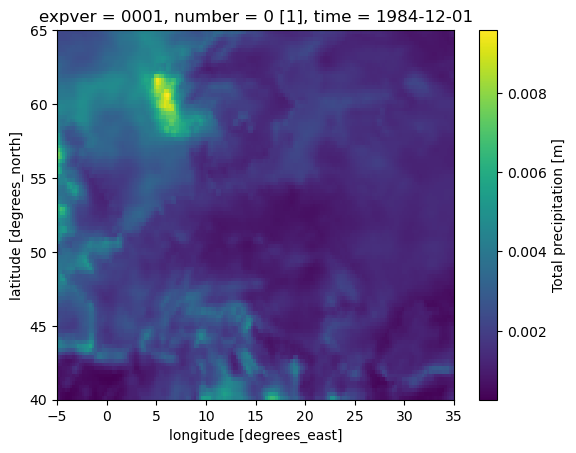

In [13]:
ds.tp.isel(time=11).plot()

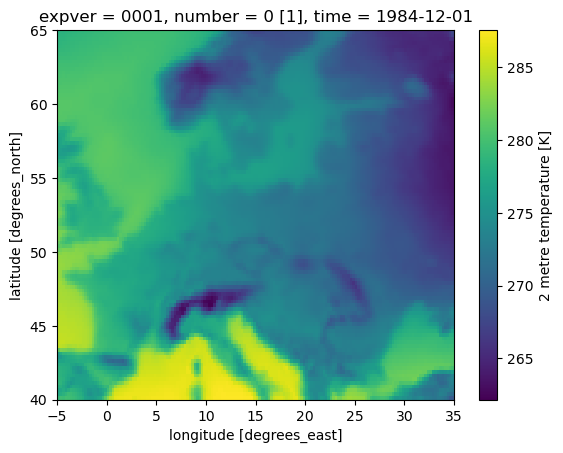

In [14]:
ds.t2m.isel(time=-1).plot()

In [15]:
ds = store_team.open_data(data_ids[-1])
ds

<xarray.Dataset> Size: 12MB
Dimensions:  (time: 12, lat: 100, lon: 160)
Coordinates:
    expver   (time) object 96B dask.array<chunksize=(12,), meta=np.ndarray>
  * lat      (lat) float64 800B 64.88 64.62 64.38 64.12 ... 40.62 40.38 40.12
  * lon      (lon) float64 1kB -4.875 -4.625 -4.375 -4.125 ... 34.38 34.62 34.88
    number   int64 8B ...
  * time     (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
Data variables: (12/16)
    d2m      (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    e        (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    lai_hv   (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    lai_lv   (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    pev      (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    skt      (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    ...       ...
    stl1     (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    stl2     (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    stl3     (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    stl4     (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    t2m      (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
    tp       (time, lat, lon) float32 768kB dask.array<chunksize=(12, 100, 160), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    institution:             European Centre for Medium-Range Weather Forecasts

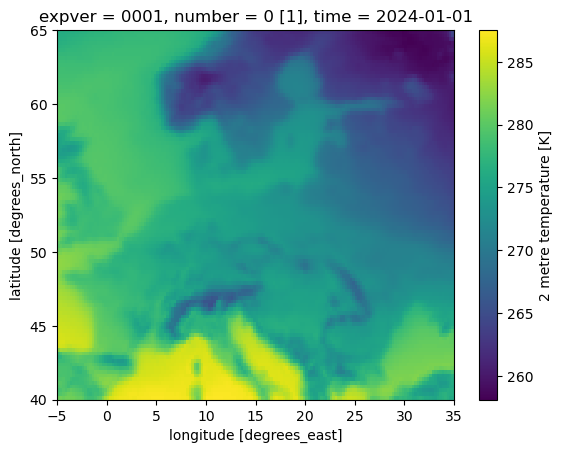

In [16]:
ds.t2m.isel(time=0).plot()

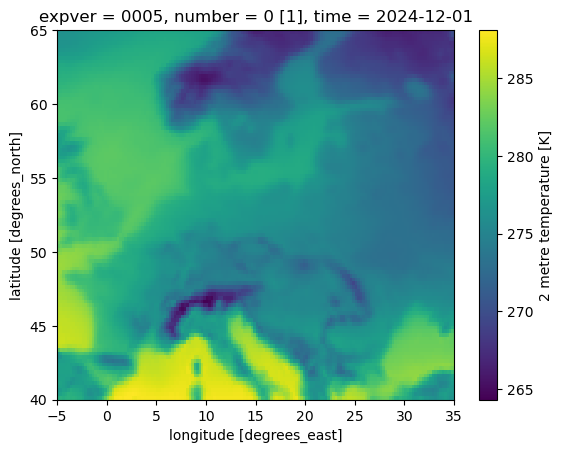

In [17]:
ds.t2m.isel(time=-1).plot()